# 暫定スコア 0.73のモデルです。
# 実行後に生成されるsubmit_20211125_2.csvが上記スコアとなります。
<b>import errorが発生した場合は、適宜、pip install などで取り込みをお願いします。</b>
## 1. 検証データ、学習データのディレクトリを指定してください。

In [1]:
TRAIN='data/train'
TEST='data/test'

## 2. 学習データ、検証データのファイル名取得

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os
from scipy.signal import hilbert
import shap

train_normal = sorted(glob(os.path.join(TRAIN, 'normal/*.csv')))
train_anomaly = sorted(glob(os.path.join(TRAIN, 'anomaly/*.csv')))
test = sorted(glob(os.path.join(TEST, '*.csv')))

print(len(train_normal),len(train_anomaly),len(test))

350 90 480


## 3. モデルの再現性を高めるためのおまじない

In [3]:
import random
# 乱数のシードを設定
SEED=2147483647

np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## 4. 以下のデータフレーム(pandas)を作成
 |カラム|内容|
 |:---|:---|
 |file|trainもしくはtest配下のcsv|
 |y|正常(True) or 異常(False)|
 |cv|cross validationで使用するkey情報(1～5)|
 

In [4]:
COLUMNS=[f'ch_{x}' for x in range(7)]

def to_dataframe(files):
    df = pd.DataFrame()
    df['file'] = files
    df['y'] = df['file'].str.contains('anomaly')
    df['cv'] = [random.randint(1,5) for i in range(len(files))]
    return df

df_train_n = to_dataframe(train_normal)
df_train_a = to_dataframe(train_anomaly)
df_test = to_dataframe(test)


## 5. 正常データ可視化
左:生の波形(raw)、右:パワースペクトル

サンプリングが約0.3秒と短いので時系列のスライドはあきらめる
scipy.signal.hilbertで波形変換(なんちゃってエンベロープ)

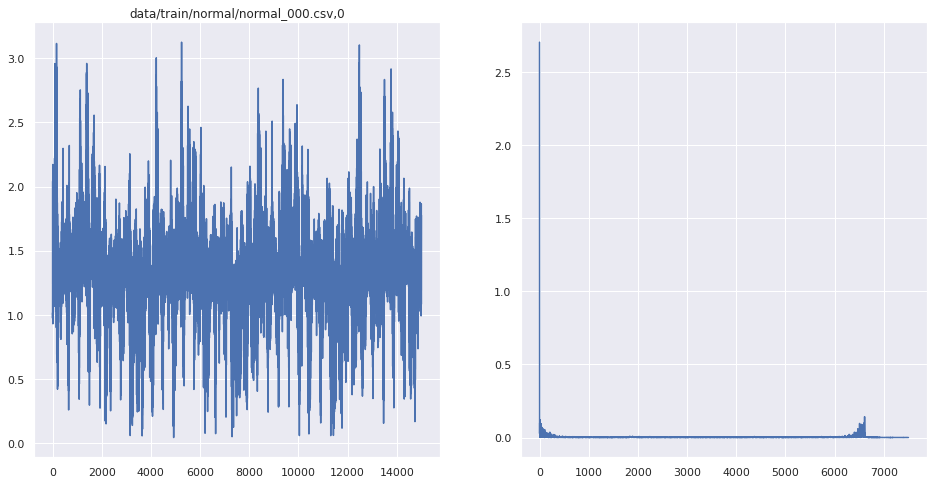

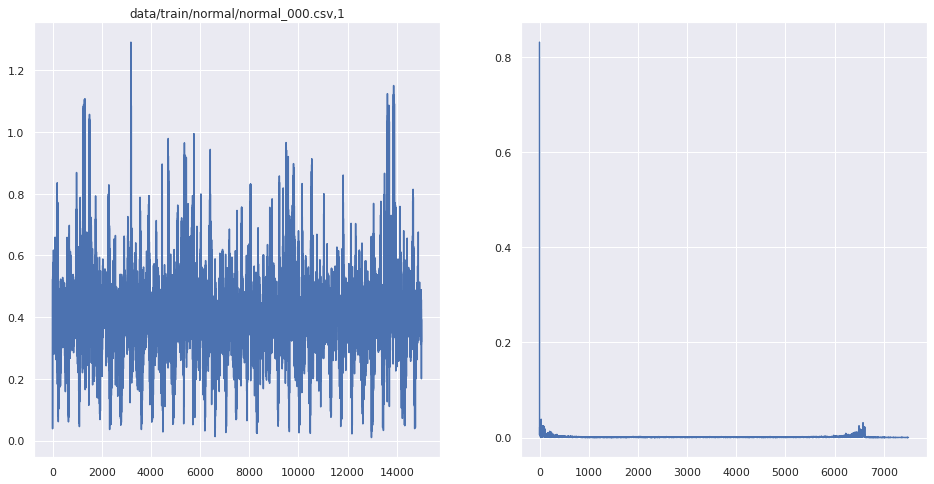

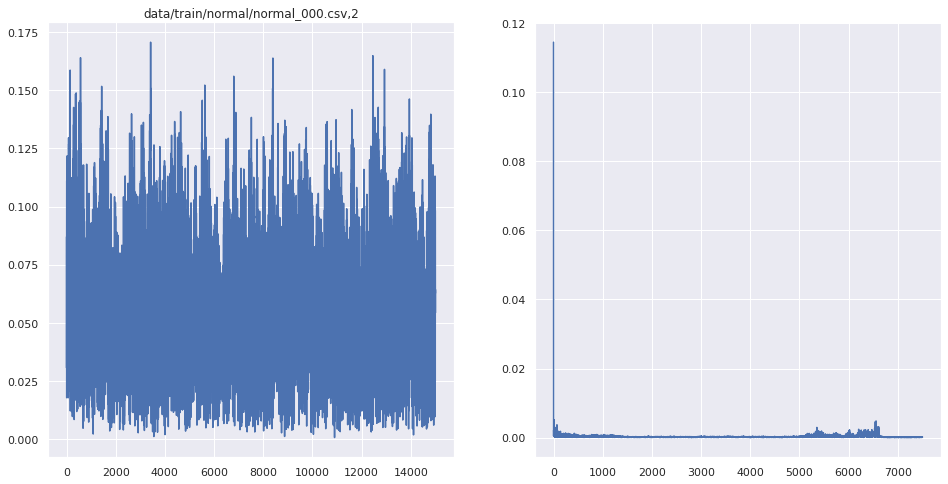

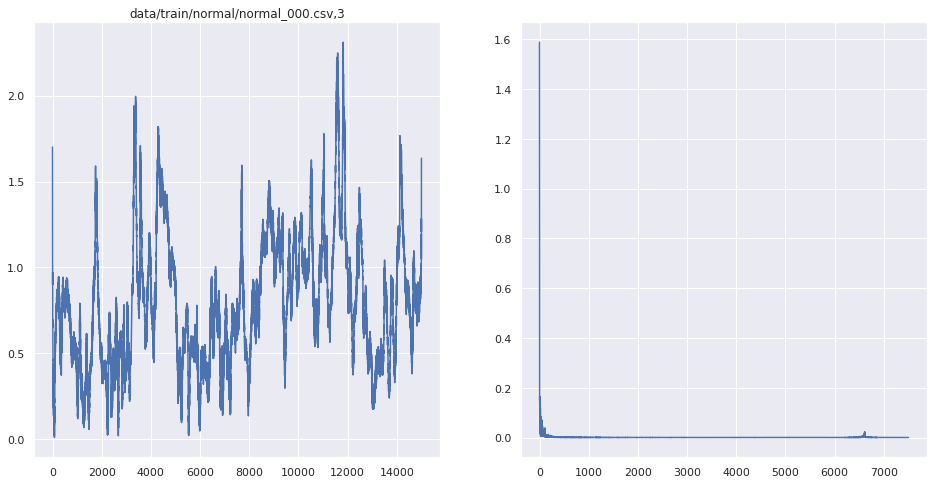

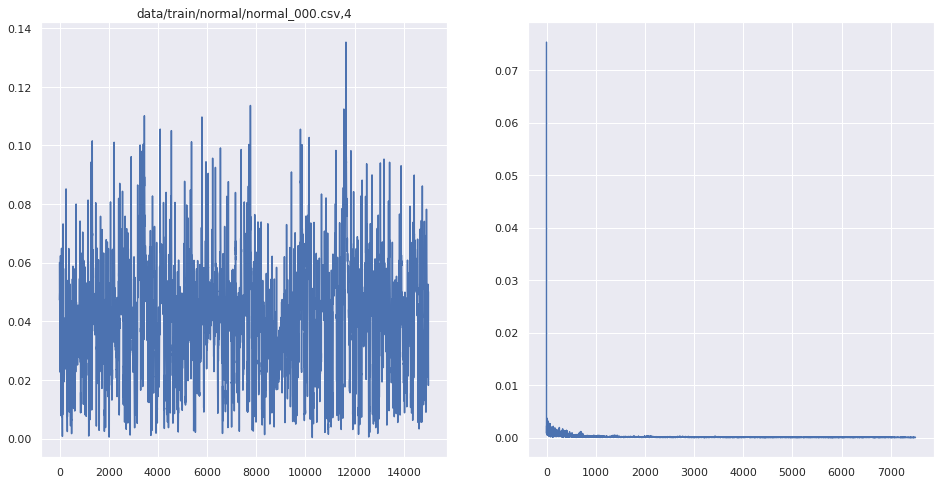

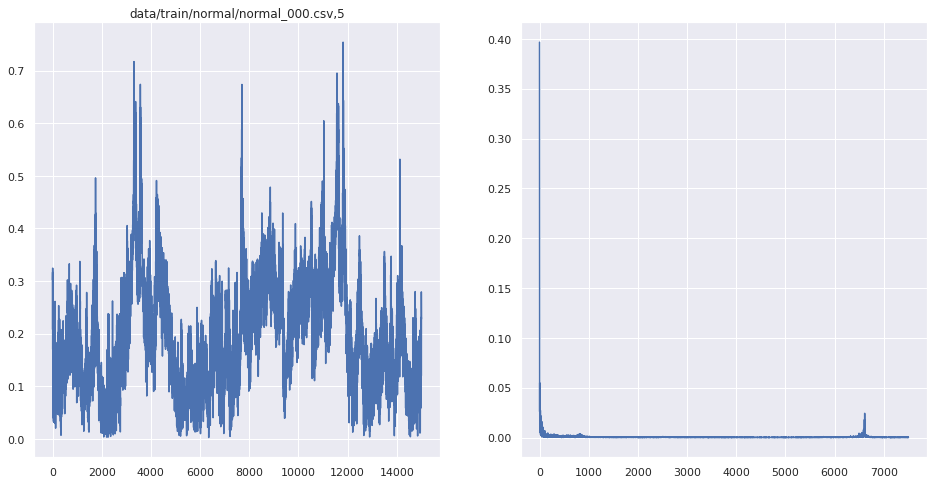

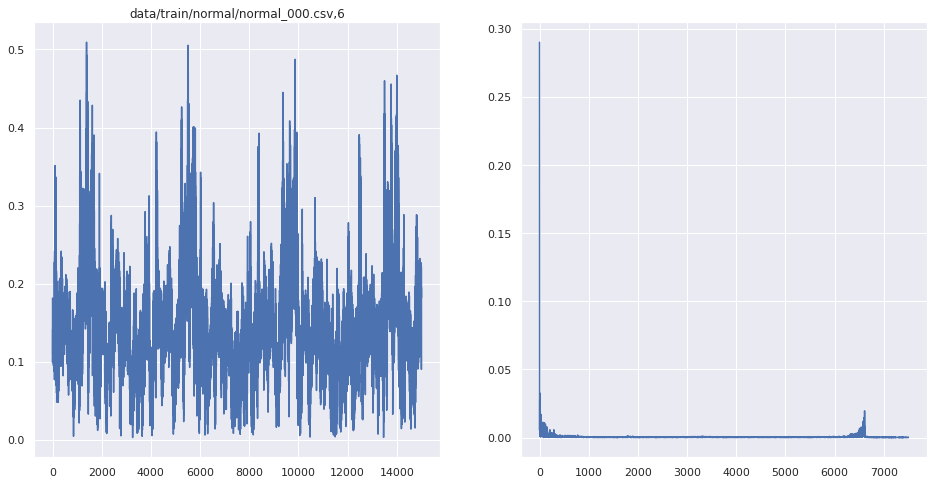

In [5]:
import librosa
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def load_data(file):
    return pd.read_csv(file, header=None, names=COLUMNS).interpolate().fillna(0).values

def to_powspec(y):
    N = 15000
    yf = fft(y)
    return 2.0/N * np.abs(yf[0:len(y)//2])

def plot_powspec(file):
    data = load_data(file)
    for ix in range(data.shape[1]):
        fig, ax = plt.subplots(1,2,figsize=(16,8))
        y = np.abs(hilbert(data[:, ix]))
        ax[0].set_title(f'{file},{ix}')
        ax[0].plot(y) 
        ax[1].plot(to_powspec(y))
        plt.show(fig)
    return
plot_powspec(train_normal[0])        

## 6. 異常データ可視化

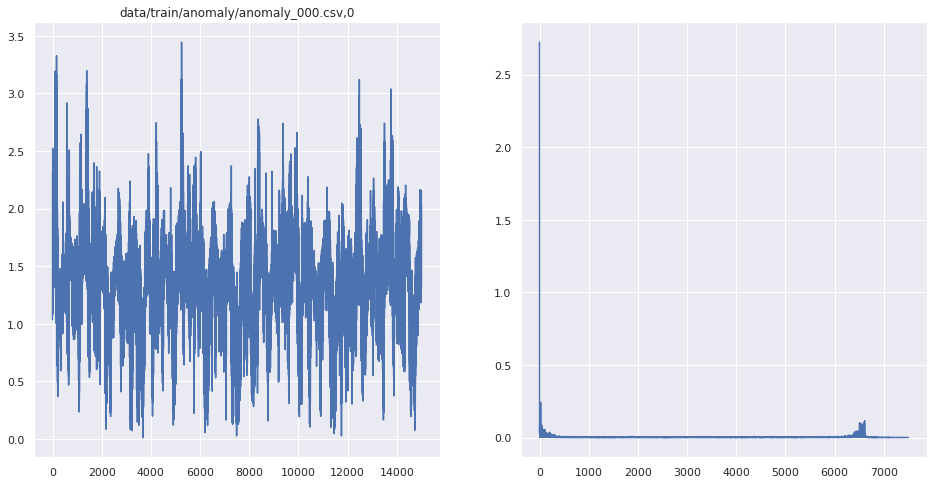

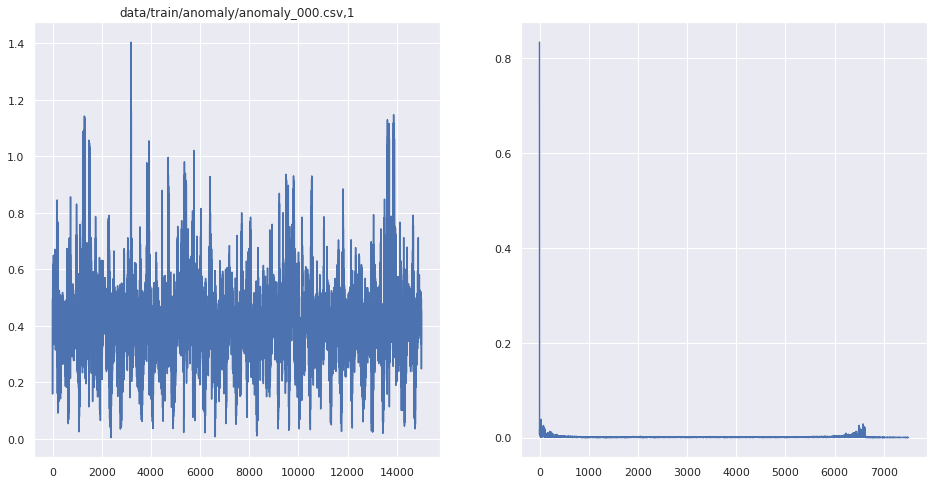

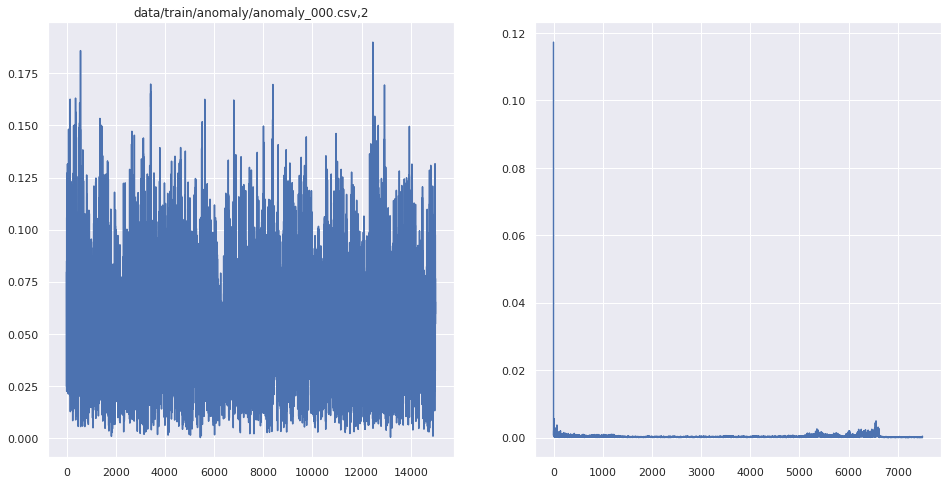

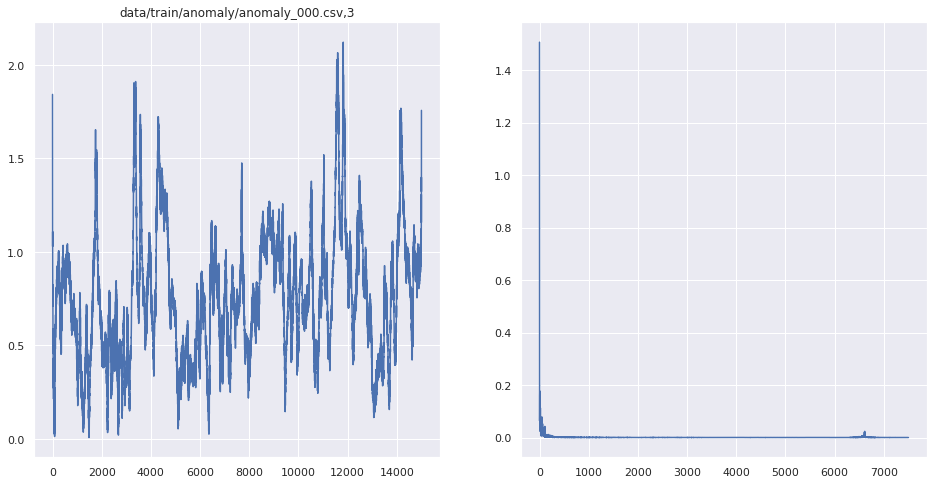

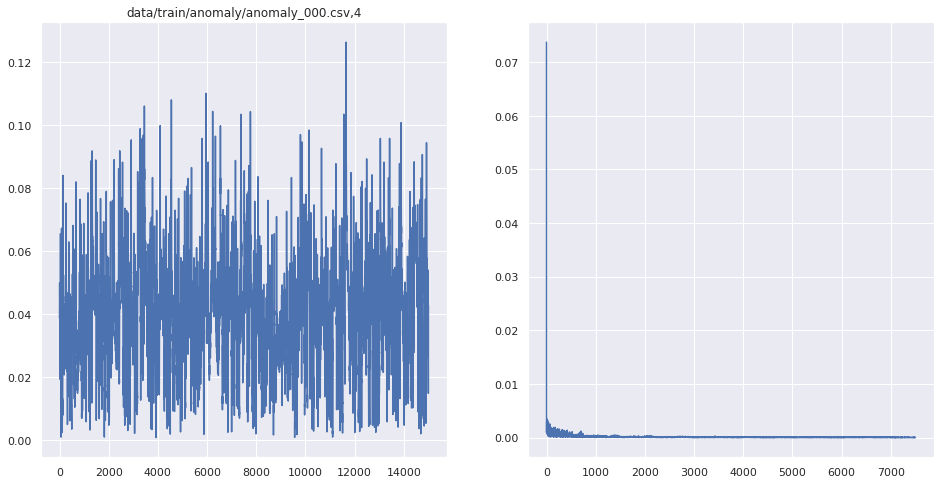

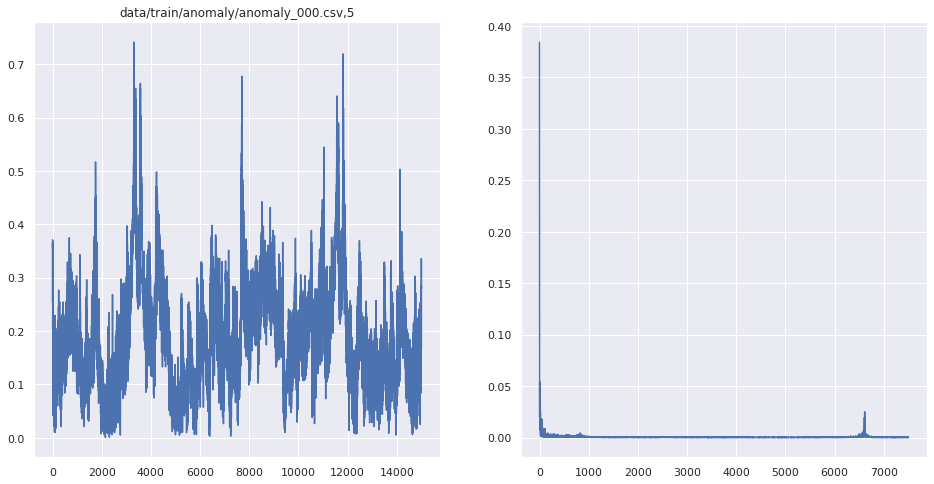

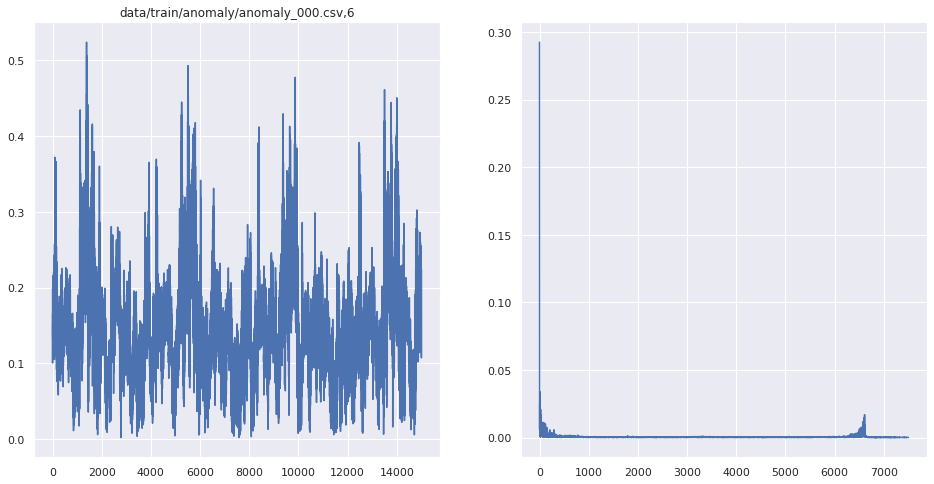

In [6]:
plot_powspec(train_anomaly[0])   

## 7. 怪しげなfeature engineering
パワースペクトルの振幅要素7500個を30個ずつ平均をとり250個に縮退

In [7]:
def wav_feature_1(file, size=30):
    data = load_data(file)
    values=[file]
    for ch in range(data.shape[1]):
        y = np.abs(hilbert(data[:,ch]))
        yf = to_powspec(y)
        value=[y.std(),librosa.zero_crossings(y).sum()]
        for i in range(len(yf)//size):
            start = i * size
            end = start + size
            if len(yf[start:end]) < size:
                break
            value.append(yf[start:end].mean())
        values.extend(value)
    return values
columns=['file']
for ch in range(7):
    columns += ([f'ch_{ch}_std', f'ch_{ch}_zc'] + [f'ch_{ch}_{ix:03d}' for ix in range(250)])

In [8]:
def convert_wav_feature_1(df):
    values=[]
    for file in df['file']:
        values.append(wav_feature_1(file))
    return pd.DataFrame(values, columns=columns)

convert_wav_feature_1(df_train_a.query('cv==1'))

,file,ch_0_std,ch_0_zc,ch_0_000,ch_0_001,ch_0_002,ch_0_003,ch_0_004,ch_0_005,ch_0_006,...,ch_6_240,ch_6_241,ch_6_242,ch_6_243,ch_6_244,ch_6_245,ch_6_246,ch_6_247,ch_6_248,ch_6_249
0,data/train/anomaly/anomaly_003.csv,0.399008,1,0.117014,0.024263,0.016210,0.013132,0.011415,0.006290,0.005647,...,0.000071,0.000066,0.000095,0.000078,0.000095,0.000077,0.000080,0.000074,0.000077,0.000063
1,data/train/anomaly/anomaly_006.csv,0.552168,1,0.154177,0.034737,0.027566,0.014330,0.014638,0.010269,0.006718,...,0.000093,0.000075,0.000065,0.000095,0.000082,0.000087,0.000078,0.000097,0.000085,0.000070
2,data/train/anomaly/anomaly_014.csv,0.484575,1,0.138583,0.026550,0.022498,0.019018,0.012198,0.009229,0.007740,...,0.000084,0.000092,0.000094,0.000069,0.000061,0.000069,0.000073,0.000068,0.000066,0.000064
3,data/train/anomaly/anomaly_033.csv,0.485676,1,0.122437,0.022725,0.018404,0.015964,0.013082,0.010224,0.009141,...,0.000101,0.000088,0.000078,0.000085,0.000082,0.000094,0.000090,0.000085,0.000074,0.000090
4,data/train/anomaly/anomaly_037.csv,0.467535,1,0.116606,0.017339,0.017510,0.015880,0.012896,0.007210,0.007424,...,0.000081,0.000075,0.000094,0.000079,0.000079,0.000095,0.000082,0.000073,0.000076,0.000064
5,data/train/anomaly/anomaly_041.csv,0.545736,1,0.122159,0.020184,0.021293,0.016256,0.014544,0.010504,0.009399,...,0.000085,0.000081,0.000086,0.000082,0.000094,0.000085,0.000077,0.000077,0.000083,0.000060
6,data/train/anomaly/anomaly_042.csv,0.447749,1,0.111193,0.015673,0.016396,0.016481,0.011556,0.009496,0.007939,...,0.000096,0.000080,0.000084,0.000084,0.000096,0.000074,0.000098,0.000094,0.000102,0.000067
7,data/train/anomaly/anomaly_044.csv,0.432880,1,0.104987,0.015980,0.016109,0.014863,0.011562,0.009039,0.007903,...,0.000090,0.000084,0.000084,0.000087,0.000110,0.000083,0.000097,0.000091,0.000097,0.000071
8,data/train/anomaly/anomaly_045.csv,0.456610,1,0.106606,0.015323,0.017332,0.015208,0.012081,0.010678,0.007181,...,0.000091,0.000084,0.000095,0.000098,0.000093,0.000073,0.000076,0.000075,0.000079,0.000078
9,data/train/anomaly/anomaly_047.csv,0.572699,1,0.120902,0.021892,0.022225,0.016129,0.015690,0.011732,0.009454,...,0.000089,0.000086,0.000083,0.000086,0.000084,0.000081,0.000081,0.000080,0.000082,0.000076


## 8. XGBoostでcross validation

In [9]:
import warnings
warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score,roc_auc_score
df_train = pd.concat([df_train_n, df_train_a])
df_feature_1 = convert_wav_feature_1(df_train)
df_train =  df_train.merge(df_feature_1,on='file')
models=[]
for cv in range(1,6):
    train = df_train.query('cv!=@cv').sample(frac=1)
    val = df_train.query('cv==@cv').sample(frac=1)
    X_train, y_train = train[columns[1:]], train['y']
    X_val, y_val = val[columns[1:]], val['y']
    
    mod = XGBClassifier(random_state=SEED).fit(X_train,y_train)
    models.append(mod)
    y_pred_val = mod.predict(X_val)
    print(f1_score(y_val, y_pred_val,average='binary'),recall_score(y_val, y_pred_val),precision_score(y_val, y_pred_val),roc_auc_score(y_val, y_pred_val))
    

[14:21:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.888888888888889 0.8 1.0 0.9
[14:21:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.717948717948718 0.56 1.0 0.78
[14:21:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8 0.6666666666666666 1.0 0.8333333333333333
[14:21:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:log

## 9. テストデータの予測
cross validationで作成したモデルを使ってアンサンブル(F値が低いmodelは不採用の方がいいかも)

In [10]:
df_test = convert_wav_feature_1(df_test)

In [11]:
df_test['key'] = df_test['file'].apply(lambda x:os.path.basename(x))
for ix, mod in enumerate(models):
    df_test[f'pred_{ix}'] = mod.predict_proba(df_test[columns[1:]])[:,1]

### 9.1 preision >> recall なので、なんとなくバランスをとるために0.3を閾値に設定
0.2の方がいい結果かもしれない

In [12]:
df_test['pred'] = df_test[[f'pred_{ix}' for ix in range(5)]].apply(lambda x:x.mean(),axis=1)
df_test['pred_final'] = (df_test['pred']>0.3).astype(int)

In [13]:
df_test[['key','pred_final']].to_csv('submit_20211125_1.csv', index=False, header=None)

## 10. LinearSVMでも予測してみる

In [14]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, recall_score, precision_score
df_train = pd.concat([df_train_n, df_train_a])
df_feature_1 = convert_wav_feature_1(df_train)
df_train =  df_train.merge(df_feature_1,on='file')
models_svc=[]
for cv in range(1,6):
    train = df_train.query('cv!=@cv').sample(frac=1)
    val = df_train.query('cv==@cv').sample(frac=1)
    X_train, y_train = train[columns[1:]], train['y']
    X_val, y_val = val[columns[1:]], val['y']
    
    mod = LinearSVC(random_state=SEED,max_iter=10000).fit(X_train,y_train)
    models_svc.append(mod)
    y_pred_val = mod.predict(X_val)
    print(f1_score(y_val, y_pred_val),recall_score(y_val, y_pred_val),precision_score(y_val, y_pred_val))
    

0.5 0.3333333333333333 1.0
0.5294117647058824 0.36 1.0
0.5 0.3333333333333333 1.0
0.4210526315789474 0.26666666666666666 1.0
0.5263157894736842 0.35714285714285715 1.0


In [15]:
for ix, mod in enumerate(models_svc):
    y_pred = mod.predict(df_test[columns[1:]])
    df_test[f'pred_svc_{ix}'] = y_pred

### 10.1. LinearSVMはprecisionが1なので、異常と検知したものは無条件に採用

In [16]:
df_test['pred_svc'] = df_test[[f'pred_svc_{ix}' for ix in range(5)]].apply(lambda x:x.sum()>0,axis=1).astype(int)
df_test['pred_final2'] = (df_test['pred_final'] | df_test['pred_svc']).astype(int)

In [17]:
df_test[['key','pred_final2']].to_csv('submit_20211125_2.csv', index=False, header=None)

## 11. XGBoostの判定をShapley値で可視化

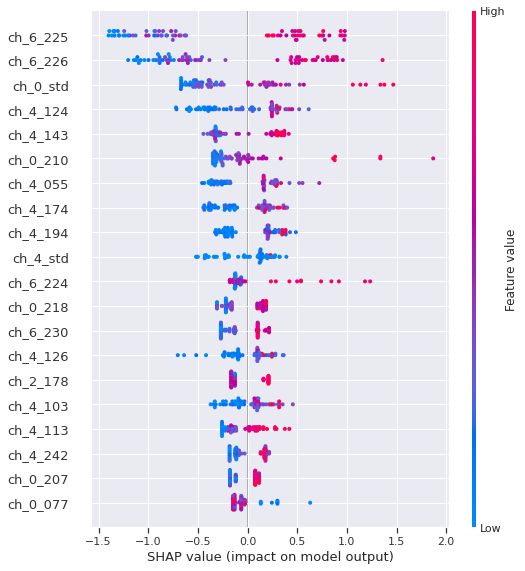

In [18]:
import shap

mod = models[0]
explainer = shap.TreeExplainer(model=mod)
shap_values = explainer.shap_values(X=X_val)
shap.summary_plot(shap_values, X_val)